In [1]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [2]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """ Display an array as a picture """
    a = (a - rng[0])/float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

In [3]:
sess = tf.InteractiveSession()

In [4]:
def make_kernel(a):
    """Transfor a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    """A simple 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

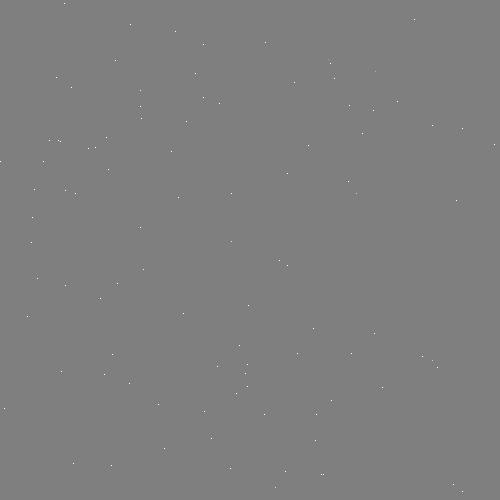

In [5]:
N = 500

# Some rain drops hit a pond

# set everthing to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# hit the pond at random points
for n in range(100):
    a, b = np.random.randint(0, N, 2)
    u_init[a, b] = np.random.uniform()
    
DisplayArray(u_init, rng=[-0.1, 0.1])

In [6]:
# differential equation
# eps -- time resolution
eps = tf.placeholder(tf.float32, shape=())
# damping - wave damping
damping = tf.placeholder(tf.float32, shape=())

# create tensors
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

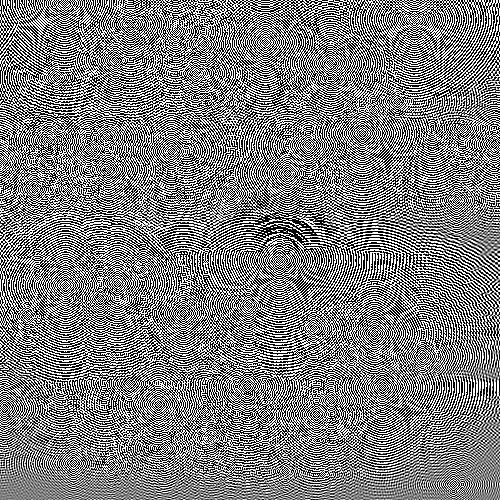

In [7]:
# run the simulation
tf.global_variables_initializer().run()

for i in range(5000):
    step.run({eps: 0.03, damping: 0.04})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])